In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"
from torchvision.datasets import CIFAR10
import open_clip
import timm

import open_clip
import torch



# Code for Results with Corruptions (CLIP(RESNET,VIT), COCA MODELS)

In [ ]:
########### NECESSARY IMPORTS
from tqdm import tqdm
import torch
from PIL import Image as im
from imagecorruptions import get_corruption_names
from imagecorruptions import corrupt
import numpy as np

##### CHOOSE THE MODEL YOU WANT TO ANALYSE
model_choice = 'CLIP_ViT'


######## LOAD CIFAR10 DATASET
from torchvision.datasets import CIFAR10
cifar10 = CIFAR10(root='./data', train=False, download=True)
text_descriptions = [f"A photo of a {label}" for label in cifar10.classes]


########## LOAD TOKENIZER AND PREPROCESSING TRANSFORMS AS PER MODEL CHOICE
if model_choice == 'CLIP_ViT':
    print('Choosing Model', model_choice)
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device = 'cuda')
    model.eval()
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    
if model_choice == 'CLIP_ResNet':
    print('Choosing Model', model_choice)
    model, _, preprocess = open_clip.create_model_and_transforms('RN101', pretrained='yfcc15m', device = 'cuda')
    model.eval()
    tokenizer = open_clip.get_tokenizer('RN101')
    
if model_choice == 'Coca':
    print('Choosing Model', model_choice)
    model, _, preprocess = open_clip.create_model_and_transforms(
      model_name="coca_ViT-L-14",
      pretrained="mscoco_finetuned_laion2B-s13B-b90k",device = 'cuda'

    )
    model.eval()
    tokenizer = open_clip.get_tokenizer('coca_ViT-L-14')



############ GET TEXTUAL ENCODINGS OR FEATURES FOR CLASS LABEL DESCRIPTIONS

text_tokens = tokenizer(text_descriptions)
with torch.no_grad():
    text_features = model.encode_text(text_tokens.cuda()).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)


#### ITERATE OVER TYPES OF CORRUPTIONS
for corruption in ['snow','gaussian_noise', 'motion_blur', 'fog']:
    #### ITERATE OVER LEVELS OF SEVERITY
    for severity in [2,5]:
        if severity == 0:
            corr = False
        else: 
            
            corr = True
            
            
        ########## ITERATE OVER DATASET AND GET PERFORMANCE
        actual = []
        predicted = []
        features = []
        iterator = iter(cifar10)
        for i,content in tqdm(enumerate(iterator)):
            img,label = content
            if corr:
                ######## CORRUPT IMAGES
                corrupted_image = corrupt(np.array(img), corruption_name=corruption, severity=severity)
                img = im.fromarray(corrupted_image)

            image = preprocess(img)
            image = image.cuda()
            
            ################ FIND COSINE SIMILARITY OF VISUAL AND TEXT FEATURES
            with torch.no_grad():
                image_features = model.encode_image(image.unsqueeze(0)).float()
                image_features /= image_features.norm(dim=-1, keepdim=True)
                features.append(image_features.cpu())
                text_probs = (100.0 *image_features @ text_features.T).softmax(dim=-1)
                top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
                
            ################ SAVE PREDICTIONS
            actual.append(label)
            predicted.extend(top_labels[:,0].cpu().numpy())


        ################ GET FINAL PERFORMANCE FOR GIVEN CORRUPTION AND SEVERITY 
        accuracy = np.mean(np.array(actual)==np.array(predicted))
        print('Performance for Model=',model_choice,'Corruption=', corruption, 'and Severity=', severity, 'is',accuracy )

Files already downloaded and verified
Choosing Model CLIP_ViT


# Code for Results with Corruptions (BLIP2)

In [1]:
########### NECESSARY IMPORTS
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess
import torch
import numpy as np
from tqdm import tqdm
import torch
from PIL import Image as im
from imagecorruptions import get_corruption_names
from imagecorruptions import corrupt


##### CHOOSE THE MODEL YOU WANT TO ANALYSE
model_choice = 'BLIP2'


######## LOAD CIFAR10 DATASET
from torchvision.datasets import CIFAR10
cifar10 = CIFAR10(root='./data', train=False, download=True)
text_descriptions = [f"A photo of a {label}" for label in cifar10.classes]


#########LOAD TOKENIZER AND PREPROCESSING TRANSFORMS FOR BLIP2
model, vis_processors, text_processors = load_model_and_preprocess("blip2_image_text_matching", "pretrain", device='cuda', is_eval=True)
model.eval()



#### ITERATE OVER TYPES OF CORRUPTIONS
for corruption in ['snow','gaussian_noise', 'motion_blur', 'fog']:
    #### ITERATE OVER LEVELS OF SEVERITY
    for severity in [0,2,5]:
        if severity == 0:
            corr = False
        else: 
            corr = True
            
        ########## ITERATE OVER DATASET AND GET PERFORMANCE
        actual = []
        predicted = []
        features = []
        iterator = iter(cifar10)
        for i,content in tqdm(enumerate(iterator)):
            img,label = content

            if corr:
                ######## CORRUPT IMAGES
                corrupted_image = corrupt(np.array(img), corruption_name=corruption, severity=severity)
                img = im.fromarray(corrupted_image)
                
            ################ FIND COSINE SIMILARITY OF VISUAL AND TEXT FEATURES
            img = vis_processors["eval"](img).unsqueeze(0).to('cuda')
            score = []
            for item in text_descriptions:
                with torch.no_grad():
                    txt = text_processors["eval"](item)
                    itc_score = model({"image": img, "text_input": txt}, match_head='itc')
                    score.append(itc_score.cpu().numpy()[0][0])
            ################ SAVE PREDICTIONS
            actual.append(label)
            predicted.append(np.argmax(score))
            
        ################ GET FINAL PERFORMANCE FOR GIVEN CORRUPTION AND SEVERITY 
        accuracy = np.mean(np.array(actual)==np.array(predicted))
        print('Performance for Model=',model_choice,'Corruption=', corruption, 'and Severity=', severity, 'is',accuracy )

## VISUALIZE LATENT FEATURES WITH t-SNE

In [2]:
def sample_points(num_features, viz_label, features):
    ind = list(np.array(actual)==viz_label)
    all_features = np.array(features)[ind, :]
    return all_features[:num_features]

############# SAMPLE 100 FEATURES FROM EACH OF THE 10 CLASSES
num_classes=10
num_features=100
f = []
y = []
for viz_label in range(num_classes):
    feat = sample_points(num_features, viz_label, features)
    f.append(feat)
    y.extend([viz_label]*num_features)

In [3]:
#############CONCATENATE FEATURES AND LABELS TOGETHER
X = np.concatenate(f).squeeze(1)
y = np.array(y)

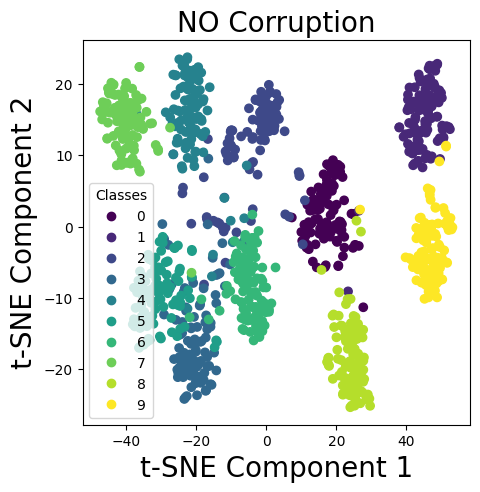

In [7]:
############# NECESSARY IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification


#################### APPLY TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Plot the 2D t-SNE representation
plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title('NO Corruption', fontsize=20)
plt.xlabel('t-SNE Component 1', fontsize=20)
plt.ylabel('t-SNE Component 2', fontsize=20)
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()





